In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})

/cerebralcortex/kessel_jupyter_virtualenv/tensorflow/lib/python3.7/site-packages/pandas-1.2.3-py3.7-linux-x86_64.egg/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [116]:
directory = './results/walking/'

In [117]:
walking = []
for f in os.listdir(directory):
    walking.append(pickle.load(open(directory+f,'rb')))

In [118]:
walking_df = pd.concat(walking)

In [142]:
thresholds = [.7,.8,.9,.95]
def get_train_test_pair(df):
    
    dmat = df[['test_lengths','majority_score']].values
    dmat = dmat[dmat[:,0].argsort()]
    rows = []
    window_size = df['train_lengths'].values[0]
    n_user = df['train_user'].values[0]
    for t in thresholds:
        dmat_temp = dmat[dmat[:,1]>=t]
        if len(dmat_temp)==0:
            continue
#         print(dmat_temp[0,0],t,window_size,n_user)
        rows.append([window_size,n_user,dmat_temp[0,0],t])
    if len(rows)==0:
        return pd.DataFrame([],columns=['train_lengths','train_user','test_lengths','threshold'])
    else:
        return pd.DataFrame(rows,columns=['train_lengths','train_user','test_lengths','threshold'])



test = walking_df.groupby(['train_lengths','train_user'],as_index=False).apply(get_train_test_pair)

In [143]:
test = test[test.train_lengths<=150].astype(np.float64)

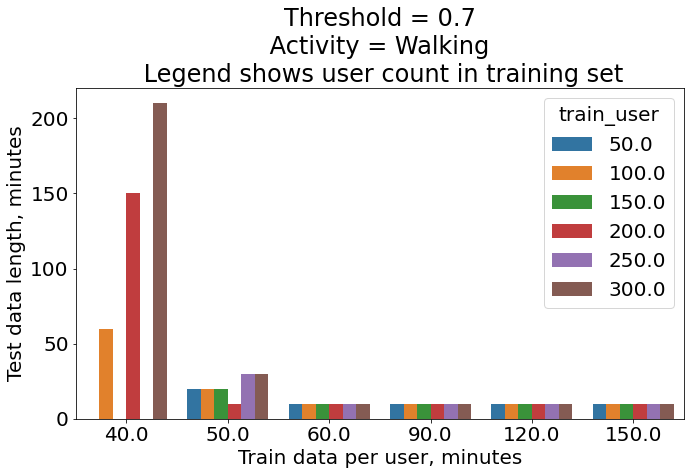

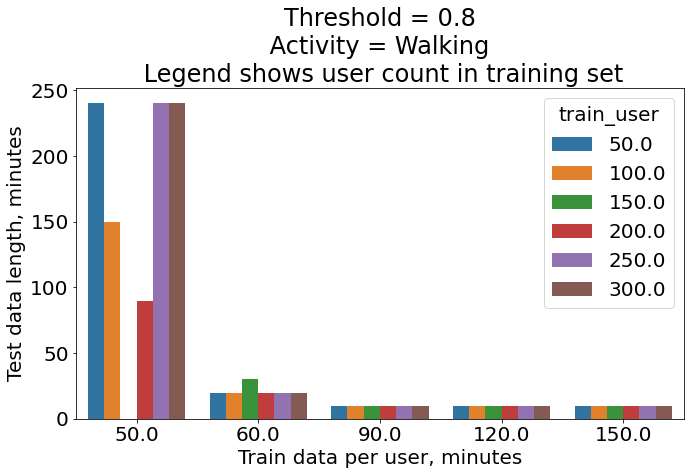

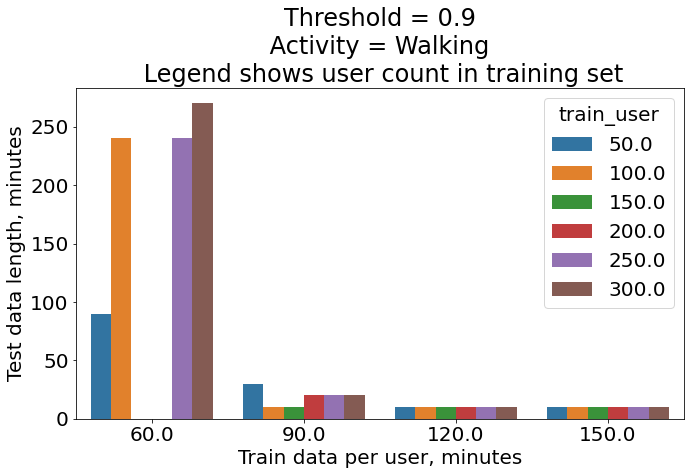

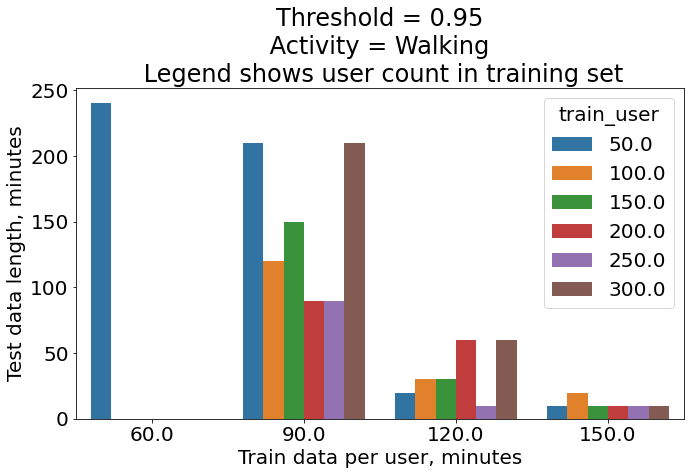

In [152]:
for t in thresholds:
    temp = test[test.threshold==t]
#     print(temp)
#     temp['train_lengths'] = temp['train_lengths']*-1
    plt.figure(figsize=(10,7))
#     temp['train_user'] = temp['train_user'].apply(lambda a:str(a)+' users')
    sns.barplot(x='train_lengths',y='test_lengths',hue='train_user',data=temp)
    plt.title('Threshold = '+str(t)+'\n Activity = Walking \n Legend shows user count in training set')
    plt.xlabel('Train data per user, minutes')
    plt.ylabel('Test data length, minutes')
    plt.tight_layout()
    plt.savefig('./images/walking/'+str(t)+'.png')
    plt.show()

In [ ]:
df = walking_df[walking_df.train_lengths==210]

In [ ]:
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(20,10))
sns.lineplot(x='test_lengths',y='majority_score',hue='train_user',data=df,linestyle='--')
plt.legend(ncol=6)
plt.xlabel('Test data length, minutes')
plt.ylabel('REID Accuracy')
plt.title('Training Data Per User = 300 minutes, \n Activity = Sitting \n Legend denotes number of users')
plt.tight_layout()
plt.savefig('./images/sitting/barplot_90_train_lengths_sitting.png')
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='test_lengths',y='majority_score',hue='train_user',data=df)
plt.legend(ncol=6)
plt.xlabel('Test data length, minutes')
plt.ylabel('REID Accuracy')
plt.title('Training Data Per User = 300 minutes, \n Activity = Walking \n Legend denotes number of users')
plt.ylim([0,1.1])
plt.tight_layout()
plt.savefig('./images/sitting/barplot_90_train_lengths_sitting.png')
plt.show()


In [ ]:
n_users = list(range(50,350,50))
for n_user in n_users:
    df = walking_df[walking_df.train_user==n_user]
    df = pd.pivot_table(df,columns='train_lengths',values='majority_score',index='test_lengths',aggfunc='mean')
    plt.figure(figsize=(20,10))
    sns.heatmap(df,annot=True,fmt='.2f',cmap='Reds',vmin=0,vmax=1)
    plt.yticks(rotation=0)
    plt.title('No. of Participants - '+str(n_user)+'\n Activity = Sitting')
    plt.xlabel('Train data per user, minutes')
    plt.ylabel('Test data length, minutes')
    plt.savefig('./images/sitting/'+str(n_user)+'.png')
    plt.show()

In [137]:
import shutil

In [153]:
shutil.make_archive('./images/walking/','zip','./images/walking/')

'/home/jupyter/mullah/mperf-activity-recognition/images/walking.zip'

In [ ]:
results = pickle.load(open('./data/walking_results_10.p','rb'))
data_col = []
for window_size,test_score,test_df,y_test,unique_users_dict in results:
#     if len(np.unique(y_test))<20:
#         continue
#     temp_df = test_df
    acc_ = accuracy_score(test_df['original'],test_df['prediction'])
    
    test_score = test_score.append(pd.DataFrame({'user':[-1],
                                    'majority_score':[acc_],
                                    'maxmean_score':[acc_],
                                    'test_lengths':[0]}))
    
    
    test_score['train_lengths'] = window_size
    
    
    
    
    
    data_col.append(test_score)
    

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
scores = pd.concat(data_col)
scores = scores[scores.test_lengths.isin(list(np.arange(1,177,8))+[0])]

In [ ]:
scores_mean = scores.groupby(['train_lengths','test_lengths'],as_index=False).mean()

In [ ]:
maxmean_score = pd.pivot_table(scores_mean,values='maxmean_score',index='test_lengths',columns='train_lengths',aggfunc='mean')

try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(20,10))
    sns.heatmap(maxmean_score,annot=True,fmt='.2f',cmap='Reds',linewidth=1,linecolor='black')
    plt.title('Max Mean Boosting')
    plt.xlabel('Train data per user, minutes')
    plt.ylabel('Test data length, minutes')
    plt.savefig('./images/maxmean_boosting.png',dps=1e6)
    plt.show()
except Exception as e:
    maxmean_score.to_json('maxmean_10.json')


In [ ]:
maxmean_score = pd.pivot_table(scores_mean,values='majority_score',index='test_lengths',columns='train_lengths',aggfunc='mean')


try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(20,10))
    sns.heatmap(maxmean_score,annot=True,fmt='.2f',cmap='Reds',linewidth=1,linecolor='black')
    plt.title('Majority Boosting')
    plt.xlabel('Train data per user, minutes')
    plt.ylabel('Test data length, minutes')
    plt.savefig('./images/majority_boosting.png',dps=1e6)
    plt.show()
except Exception as e:
    maxmean_score.to_json('majority_10.json')